
# Data preprocessing and normalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 !pip install pydicom

     |████████████████████████████████| 1.9MB 6.8MB/s 


In [3]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import math
import glob

%matplotlib inline

Add Data path & get the list of patients by their IDs

In [4]:
# Data Path
data_labels = pd.read_csv('/content/drive/MyDrive/research/Lung-Cancer-Detection-using-CNN-and-RNN/stage1_labels.csv',index_col=0,encoding='utf-8',skipinitialspace=True) #,usecols=[1]
data_dir = '/content/drive/MyDrive/Sample_CT_Scan_Data/'
patients = os.listdir(data_dir)
#test_patients = pd.read_csv('/content/drive/MyDrive/research/Lung-Cancer-Detection-using-CNN-and-RNN/stage1_sample_submission.csv')

#pixel_data = []
#paths = glob.glob("/content/drive/MyDrive/Sample_CT_Scan_Data/***.dcm")
#patients = glob.glob("/content/drive/MyDrive/Sample_CT_Scan_Data/***.dcm")
#data_dir = glob.glob("/content/drive/MyDrive/Sample_CT_Scan_Data/")


#data_labels = pd.read_csv(st1_csv, index_col=0, header=0)
#data_labels = pd.concat(map(pd.read_csv, glob.glob('/content/drive/MyDrive/research/Lung-Cancer-Detection-using-CNN-and-RNN/stage1_labels.csv')))
data_labels.head()
#data_labels.columns[0]

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [5]:
len(patients)

186

Get the respective data of each patients

In [7]:
for idx, patient in enumerate(patients[:1]):

    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']

    slices = [pydicom.read_file(data_dir+'/'+s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

186 1
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.55.267110417025483365548163432935644660141
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.267110417025483365548163432935644660141
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(

In [8]:
for idx, patient in enumerate(patients[:1]):

    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']
    
    slices = [pydicom.read_file(data_dir+'/'+s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 186


All of our images are the same size, but the slices are not.

View the first patient's first slices using matplotlib

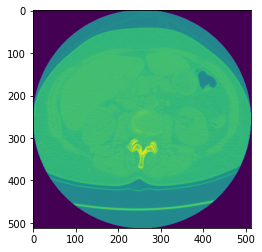

In [9]:
for idx, patient in enumerate(patients[:1]):

    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']
    
    slices = [pydicom.read_file(data_dir+'/'+s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    plt.imshow(slices[0].pixel_array)
    plt.show()

We have about 200 slices, so we're resizing our images from 512x512 to 50x50. to view some more images.

In [10]:
# Reduced Image pixel size
IMG_PX_SIZE = 50
HM_SLICES = 20

view first 12 slices after resize

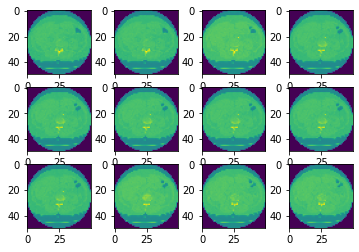

In [11]:
for idx, patient in enumerate(patients[:1]):

    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']

    slices = [pydicom.read_file(data_dir + '/' + s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

Function to break a list of slices into chunks of lists

because if we take any list of images we just need fixed number of scan.


In [12]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [13]:
def mean(l):
    return sum(l) / len(l)

Ceiling the images


some patients don't have labels, so we'll just pass those labels

In [15]:
for idx, patient in enumerate(patients[:1]):

    try:
        row_index = data_labels['cancer'].index.values[idx]
        label = data_labels.at[row_index, 'cancer']

        slices = [pydicom.read_file(data_dir + '/' + s) for s in os.listdir(data_dir)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        pass

186 19


Ceiling all into 20

In [16]:
for idx, patient in enumerate(patients[:3]):
    try:
        row_index = data_labels['cancer'].index.values[idx]
        label = data_labels.at[row_index, 'cancer']

        slices = [pydicom.read_file(data_dir + '/' + s) for s in os.listdir(data_dir)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        print(str(e))


186 20
186 20
186 20


view imges after Ceiling & resizing

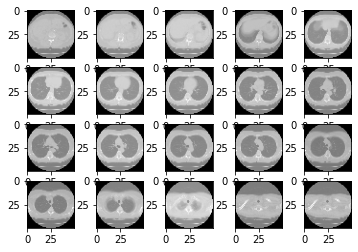

In [17]:
for idx, patient in enumerate(patients[:1]):
    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']

    slices = [pydicom.read_file(data_dir + '/' + s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

preprocss data final funtion


In [18]:
def process_data(idx,patient,data_labels,img_px_size=50, hm_slices=20, visualize=False):
    
    row_index = data_labels['cancer'].index.values[idx]
    label = data_labels.at[row_index, 'cancer']

    slices = [pydicom.read_file(data_dir + '/' + s) for s in os.listdir(data_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

Save processed data in a list

In [19]:
train_data = []

test_data = []

for idx, patient in enumerate(patients):
        if idx%50 == 0:
            print(idx)

        try:
            img_data, label = process_data(idx,patient, data_labels, IMG_PX_SIZE, HM_SLICES)
            train_data.append([img_data,label])
            print(img_data.shape, label)

        except KeyError as e:
            test_data.append([img_data])
            print(img_data.shape , '\tThis is unlabeled data')

np.save('traindata-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,HM_SLICES), train_data)
np.save('testdata-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,HM_SLICES), test_data)
print('Finished processing')

0
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [0 1]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
50
(20, 50, 50) [1 0]
(20, 50, 50) [1 0]
(20, 50

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Next part is create 3D Convolutional Neural Network 

Thank You...